In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# ML libraries
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import math
from datetime import date, datetime
import datetime as dtm

In [47]:
# Get stock quotes
tckr = "TSLA" # ticker
start = "2012-01-01"
end = "2023-07-01"
df = yf.download(tckr, start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
...,...,...,...,...,...,...
2023-06-26,250.070007,258.369995,240.699997,241.050003,241.050003,179990600
2023-06-27,243.240005,250.389999,240.850006,250.210007,250.210007,164968200
2023-06-28,249.699997,259.880005,248.889999,256.239990,256.239990,159770800


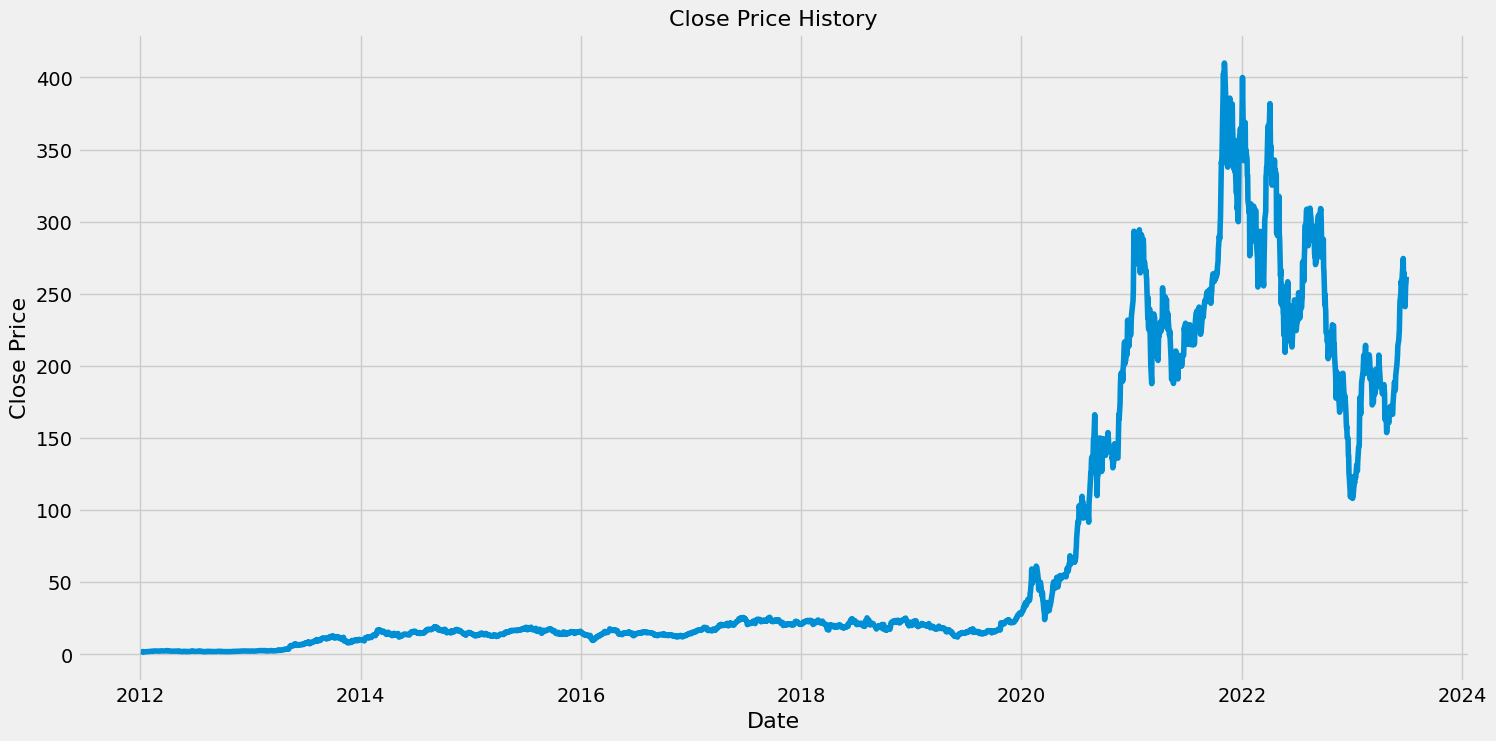

In [48]:
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(df.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()

In [49]:
# New dataframe with only close column
data = df.filter(["Close"])
# Convert the dataframe into a numpy array
dataset = data.values

In [50]:
# Get length of training and testing data
training_data_len = math.ceil(len(dataset) * 0.8)
test_data_len = len(dataset) - training_data_len
print(training_data_len, test_data_len)

2314 578


In [51]:
# Scale down data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00086343],
       [0.00080303],
       [0.00070674],
       ...,
       [0.62362649],
       [0.62671134],
       [0.63716546]])

In [52]:
# Split dataset into xtrain and ytrain
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)): 
    x_train.append(train_data[i-60: i, 0])
    y_train.append(train_data[i, 0])

In [53]:
# Convert xtrain and ytrain to numpy arrays for lstm model
x_train, y_train = np.array(x_train), np.array(y_train)

In [54]:
# Reshape to 3D, the required format for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2254, 60, 1)

In [55]:
# LSTM Model
model = Sequential()

# First layer
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Second layer
model.add(LSTM(50, return_sequences=False))
# Third layer
model.add(Dense(25))
# Fourth layer
model.add(Dense(1))

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, batch_size=1, epochs=1)

2254/2254 [==============================] - 19s 8ms/step - loss: 0.0013


In [58]:
model.save("new_us_lstm_model")

INFO:tensorflow:Assets written to: new_us_lstm_model2/assets


INFO:tensorflow:Assets written to: new_us_lstm_model2/assets


In [59]:
# Testing dataset
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

# Convert to numpy arrays
x_test = np.array(x_test)

In [60]:
# Reshape to 3D format
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(578, 60, 1)

In [61]:
# Get the models predicted values
predictions = model.predict(x_test)
# Scale down data
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 0s 5ms/step


In [62]:
# Evaluate Model
# Get RMSE - root mean square error
# The closer the number to zero, the closer the predicted values to original values,
#  the better it was predicting 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5.439607613639436

/var/folders/4f/xy4jvtjs1qg16v7xbbpgsc840000gn/T/ipykernel_59372/1099830945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


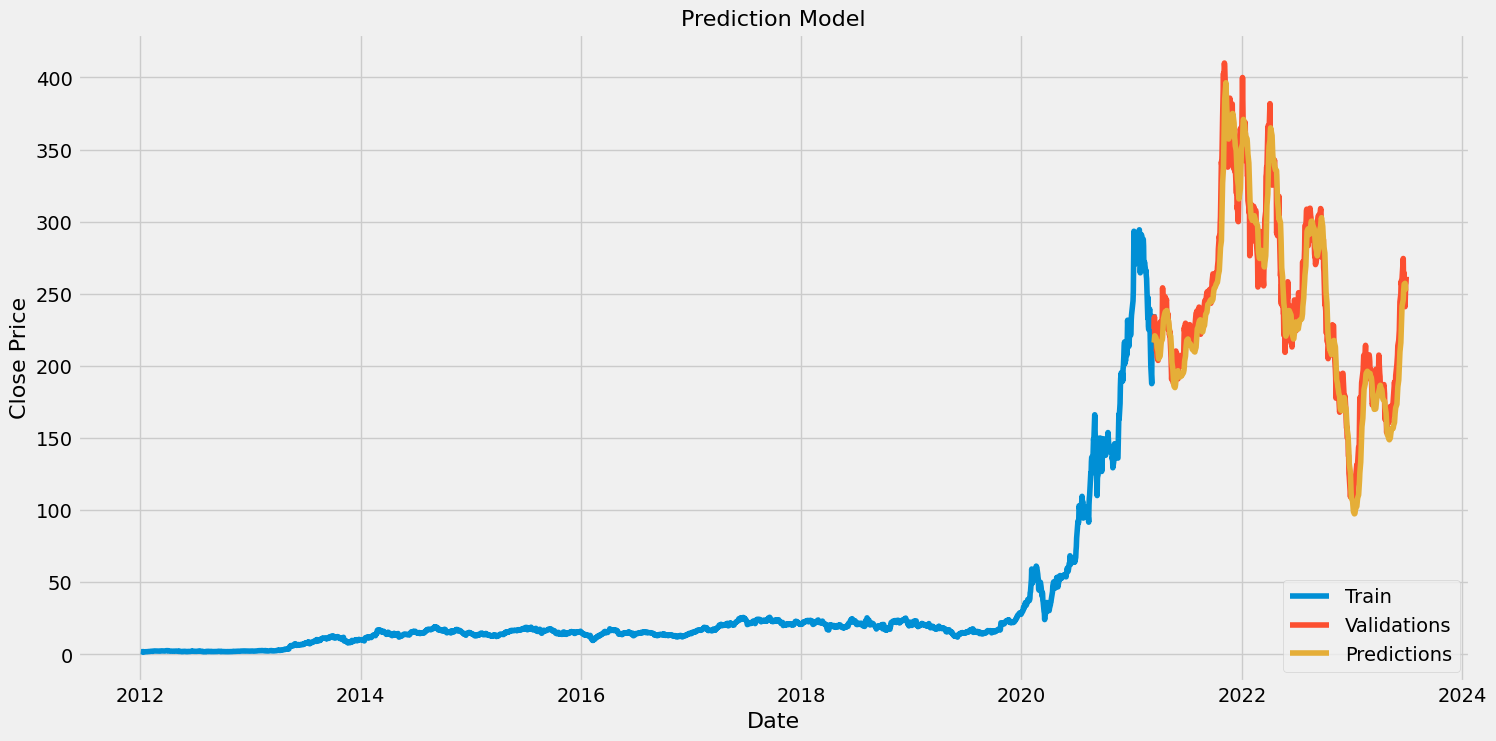

In [63]:
# Plot data
train = data[0: training_data_len] # from zero
valid = data[training_data_len:] # validation data
valid["Predictions"] = predictions

# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(train.Close)
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validations", "Predictions"], loc="lower right")
plt.show()

In [64]:
# Show valid and predicted
valid

,Close,Predictions
Date,,
2021-03-16,225.626663,216.151398
2021-03-17,233.936661,218.492218
2021-03-18,217.720001,220.873505
2021-03-19,218.289993,220.696487
2021-03-22,223.333328,219.431442
...,...,...
2023-06-26,241.050003,257.229675
2023-06-27,250.210007,254.790207
2023-06-28,256.239990,252.520218


In [65]:
# Predict for the next n_days => n_days can be 10, 20, 30, 60, 100 days e.t.c
n_days = 30
# Create new dataframe
new_df = df.filter(["Close"])

# Combined dataframe: Contains original close prices and predicted prices
combined = new_df

data = {
    "Date": [],
    "Close": []
}
next_n_days = pd.DataFrame(data)
next_n_days.set_index('Date', inplace=True)

last_day = dtm.datetime.strptime(end, "%Y-%m-%d")
last_day = last_day - dtm.timedelta(days=1)
last_day = last_day.strftime("%Y-%m-%d")
last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")

for i in range(n_days):
    # Get the last 100 days closing price and convert dataframe to an array
    last_n_days = combined[-100:].values
    # Scale down data
    last_n_days_scaled = scaler.transform(last_n_days)
    X_test = []
    X_test.append(last_n_days_scaled)
    # Convert to numpy arrays
    X_test = np.array(X_test)
    # Reshape to 3D format
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Predicted price
    pred_price = model.predict(X_test)
    # Scale up
    pred_price = scaler.inverse_transform(pred_price)
    
    #. Update dataframe with predicted value
    tomorrow = last_day + dtm.timedelta(days=1)
    # tomorrow = tomorrow.strftime("%Y-%m-%d")
    new_row = {
        "Date": [tomorrow],
        "Close": [pred_price[0].tolist()[0]]
    }
    last_day = tomorrow
    # last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")
    
    next_day = pd.DataFrame(new_row)
    next_day.set_index('Date', inplace=True)
    next_n_days = pd.concat([next_n_days, next_day])
    combined = pd.concat([combined, next_day])

1/1 [==============================] - 0s 12ms/step


In [66]:
new_df

,Close
Date,
2012-01-03,1.872000
2012-01-04,1.847333
2012-01-05,1.808000
2012-01-06,1.794000
2012-01-09,1.816667
...,...
2023-06-26,241.050003
2023-06-27,250.210007
2023-06-28,256.239990


In [67]:
next_n_days

,Close
Date,
2023-07-01,252.020752
2023-07-02,251.866425
2023-07-03,251.275940
2023-07-04,250.466705
2023-07-05,249.544388
2023-07-06,248.559464
2023-07-07,247.535767
2023-07-08,246.483963
2023-07-09,245.408905


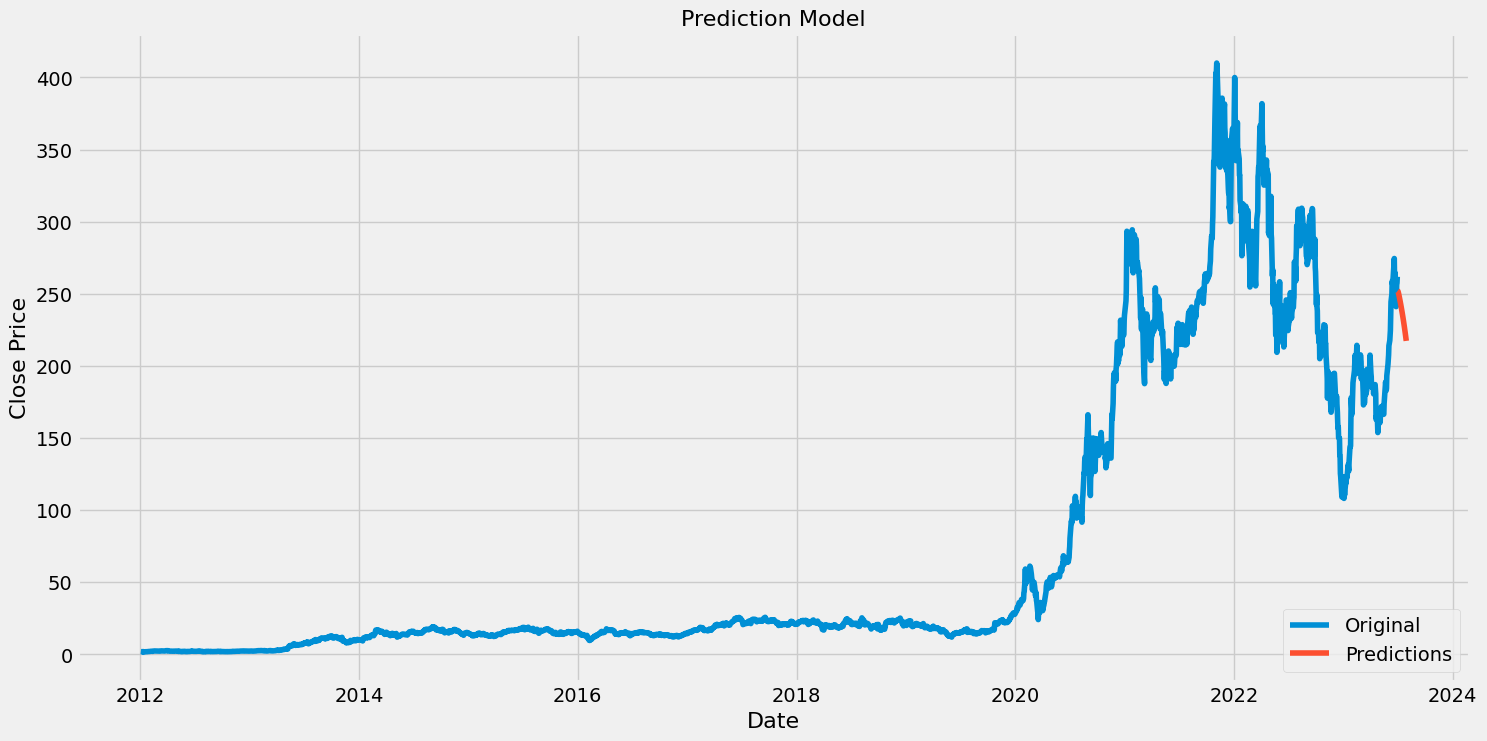

In [68]:
# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(new_df.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"], loc="lower right")
plt.show()

In [69]:
# OPTIONAL
# Campare predicted closing price as shown in red graph above and actual closing prices
new_end_date = dtm.datetime.strptime(end, "%Y-%m-%d")
new_end_date = new_end_date + dtm.timedelta(days=n_days)
new_end_date = new_end_date.strftime("%Y-%m-%d")
actual_quote = yf.download(tckr, start, new_end_date)
actual_quote

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
...,...,...,...,...,...,...
2023-07-24,255.850006,269.850006,254.119995,269.059998,269.059998,136508500
2023-07-25,272.380005,272.899994,265.000000,265.279999,265.279999,112757300
2023-07-26,263.250000,268.040009,261.750000,264.350006,264.350006,95856200


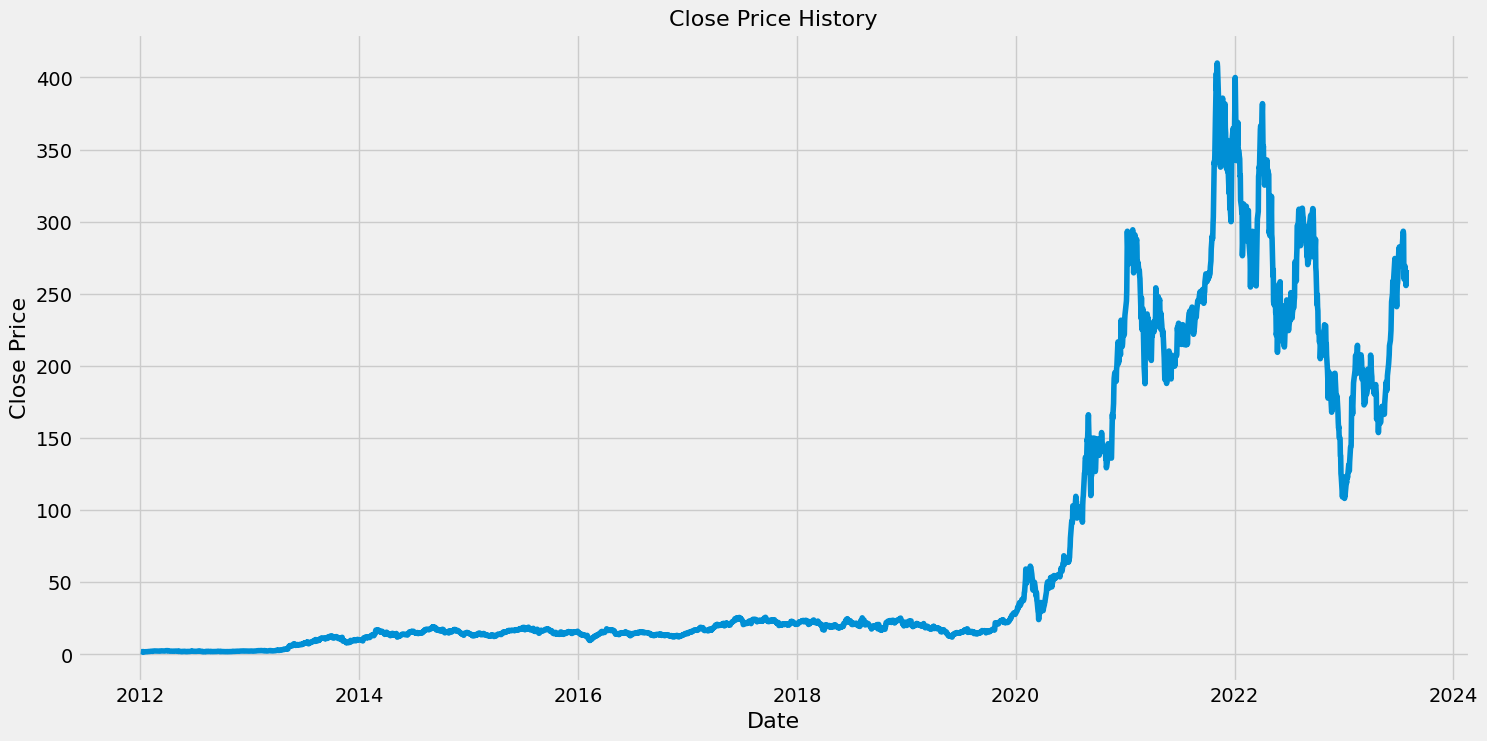

In [70]:
# Visualise actual quote
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(actual_quote.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()